In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
import math
import utils
from collections import deque
import random
import seaborn as sns
from sklearn import preprocessing
from keras.layers import Dense, Dropout, LSTM, GRU, BatchNormalization
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
import time
import data_manipulator
import create_model
import data_reader
import finance_calculator
import latex
from matplotlib.ticker import MaxNLocator

sns.set_theme()
sns.set_style("whitegrid", {'grid.linestyle': '--'})
seq_col_brew = sns.color_palette("flag_r", 4)
sns.set_palette(seq_col_brew)
plt.rcParams["figure.figsize"] = (7,4)
plt.rcParams["axes.titlesize"] = 22
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["legend.fontsize"] = 13
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Helvetica'
plt.rcParams['savefig.dpi'] = 1200
tf.keras.utils.set_random_seed(2)

%reload_ext autoreload
%autoreload 3
%config InteractiveShell.ast_node_interactivity = 'all'
%config InlineBackend.figure_format = 'retina'

Set Parameters

In [38]:
model_name = utils.model_loader()
SEQ_LEN = int(model_name[15:17])
ASSET_TO_PREDICT = model_name[11:14]  
print(f'SEQ_LEN: {SEQ_LEN}\nASSET_TO_PREDICT: {ASSET_TO_PREDICT}')


Model name from latest run was loaded.
Last model name: 01.30.1832-rx1-60-1-gru-sigmoid-30-8
SEQ_LEN: 60
ASSET_TO_PREDICT: rx1


Load history, plot and save figures.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


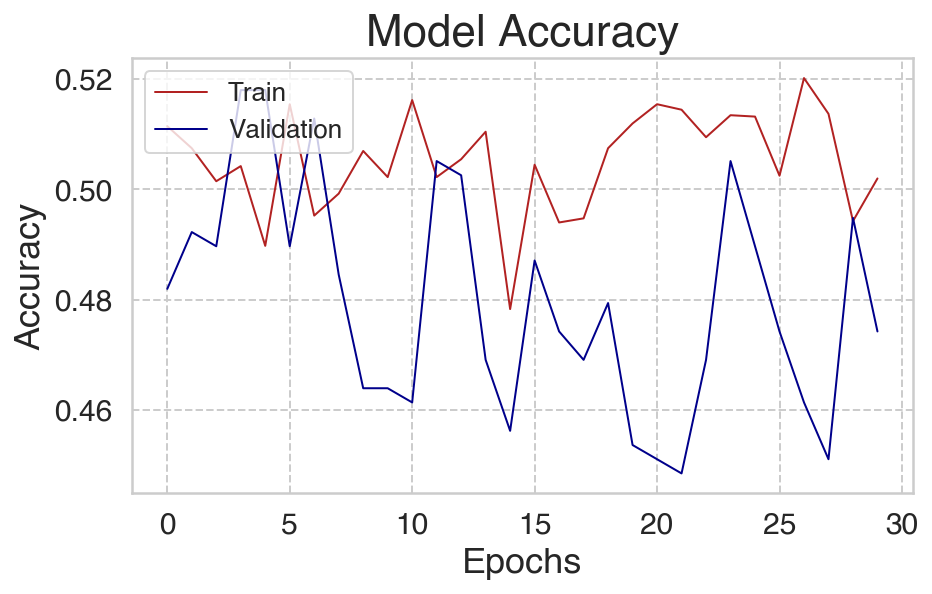

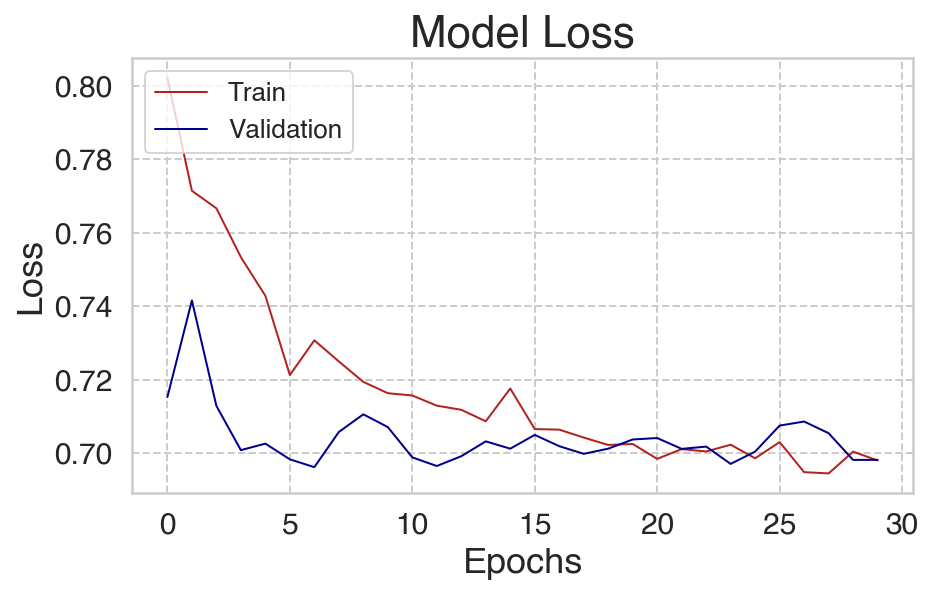

In [27]:
model_load = keras.models.load_model(f'models/{model_name}.hdf5')
history_load = np.load(f'history/{model_name}.npy',allow_pickle='TRUE').item()
fig1, axs1 = utils.plot_history_data_accuracy(history_load)
plt.tick_params(axis='both', which='major', labelsize=15)
save_loc = f'plots/{model_name}_model_accuracy.eps'
plt.savefig(save_loc, dpi=1200, bbox_inches = "tight")
#2
fig2, axs2 = utils.plot_history_data_loss(history_load)
plt.tick_params(axis='both', which='major', labelsize=15)
save_loc = f'plots/{model_name}_model_loss.eps'
plt.savefig(save_loc, dpi=1200, bbox_inches = "tight")

In [28]:
dataset_df = data_reader.credit_selector(ASSET_TO_PREDICT)
model_test_df = data_manipulator.splitter(dataset_df, cutoff=0.10)[1]
return_pred_df = utils.getReturnAndPred_sigmoidModel(model_test_df, SEQ_LEN+1, ASSET_TO_PREDICT, model_load)

Pred #75: [0.4861098]
Pred #100: [0.4784532]
Pred #125: [0.47618672]
Pred #150: [0.505882]
Pred #175: [0.48676625]
Pred #200: [0.49711046]
Pred #225: [0.4712104]
Pred #250: [0.46683797]
Pred #275: [0.49193382]
Pred #300: [0.48160738]
Pred #325: [0.47607118]
Pred #350: [0.48273352]
Pred #375: [0.49104786]
Pred #400: [0.4945647]
Pred #425: [0.4958503]
Pred #450: [0.4832633]
Pred #475: [0.47544143]
Pred #500: [0.46612015]
Pred #525: [0.5304792]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


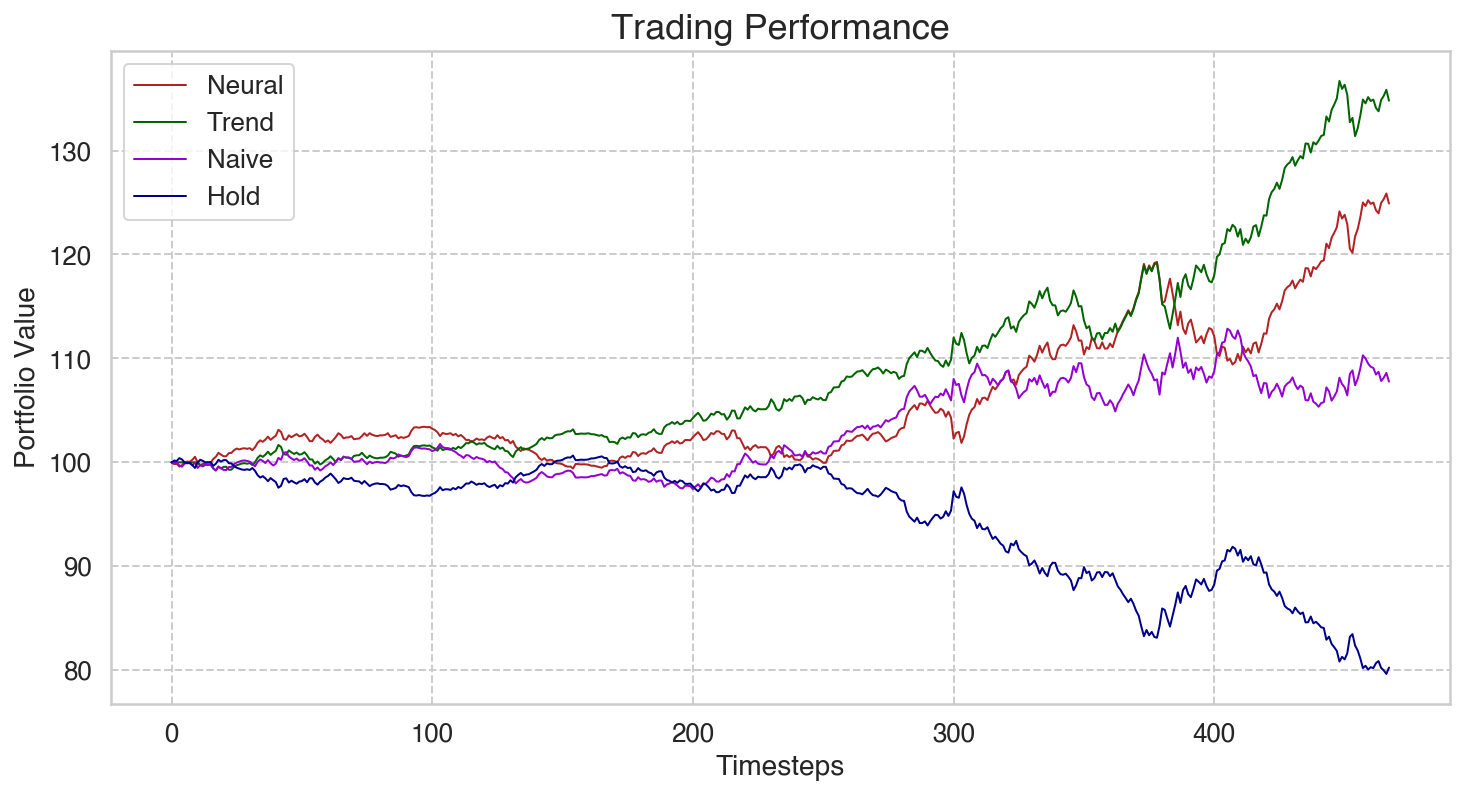

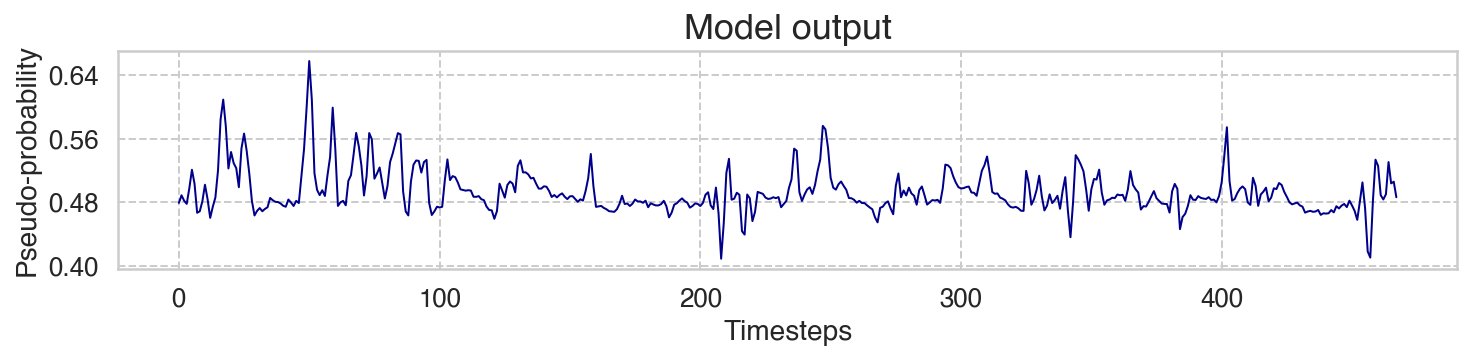

In [70]:
# n = 20                       #---var change
# first_n_predictions = return_pred_df.loc[0:n, 'probability_up']
# mean = np.mean(first_n_predictions)
# print(f'Mean of {n} first predictions', mean)

treshhold = 0.55           # 1 = always short, 0 = always long. mean ~ 50/50 short/long
copy_df = return_pred_df[0:].reset_index(drop=True)          #if treshhold calculated above, 0 must change to n here!

# Portfolio values
portfolio_value_neural = finance_calculator.portfolio_value_neural(copy_df, treshhold)
nbr_previous_days = 10
portfolio_value_trend = finance_calculator.portfolio_value_trend(copy_df, nbr_previous_days)
portfolio_value_naive = finance_calculator.portfolio_value_naive(copy_df)
portfolio_value_hold = finance_calculator.portfolio_value_hold(copy_df)

# Plots
fig1, axs1 = plt.subplots(1,1, figsize=(12,6))
plt.tick_params(axis='both', which='major', labelsize=13)
fig1 = plt.plot(portfolio_value_neural, color='firebrick', linestyle='-', linewidth='1')
fig1 = plt.plot(portfolio_value_trend, color='darkgreen', linestyle='-', linewidth='1')
fig1 = plt.plot(portfolio_value_naive, color='darkviolet', linestyle='-', linewidth='1')
fig1 = plt.plot(portfolio_value_hold, color='darkblue', linestyle='-', linewidth='1')
axs1.yaxis.set_major_locator(MaxNLocator(7)) 
axs1 = plt.title('Trading Performance', size=18)
axs1 = plt.ylabel('Portfolio Value', size=14)
axs1 = plt.xlabel('Timesteps', size=14)
axs1 = plt.legend(['Neural', 'Trend', 'Naive', 'Hold'], loc='upper left')
save_loc = f'plots/{model_name}_trading_performance.eps'
plt.savefig(save_loc, dpi=1200, bbox_inches = "tight")

# Model output
fig2, axs2 = plt.subplots(1,1, figsize=(12,2))
plt.tick_params(axis='both', which='major', labelsize=13)
axs2.yaxis.set_major_locator(MaxNLocator(4)) 
fig2 = plt.plot(copy_df['probability_up'], color='darkblue', linewidth='1')
axs2 = plt.title('Model output', size=18)
axs2 = plt.ylabel('Pseudo-probability', size=14)
axs2 = plt.xlabel('Timesteps', size=14)
save_loc = f'plots/{model_name}_model_output.eps'
plt.savefig(save_loc, dpi=1200, bbox_inches = "tight")


In [71]:
# Financial Metrics
one_year_of_returns_for_portfolio = 365 #number of datapoints that equals one year of return data in portfolio value
print('NEURAL')
finance_calculator.portfolio_financial_stats(portfolio_value_neural, one_year_of_returns_for_portfolio)
print('\nTREND')
finance_calculator.portfolio_financial_stats(portfolio_value_trend, one_year_of_returns_for_portfolio)
print('\nNAIVE')
finance_calculator.portfolio_financial_stats(portfolio_value_naive, one_year_of_returns_for_portfolio)
print('\nHOLD')
finance_calculator.portfolio_financial_stats(portfolio_value_hold, one_year_of_returns_for_portfolio)


NEURAL
Sharpe-ratio:  1.74
Sortino-ratio:  2.29
Gross return: 24.90%
Maximal Drawdown: -8.27%

TREND
Sharpe-ratio:  2.42
Sortino-ratio:  3.42
Gross return: 34.79%
Maximal Drawdown: -5.30%

NAIVE
Sharpe-ratio:  0.47
Sortino-ratio:  0.74
Gross return:  7.77%
Maximal Drawdown: -6.66%

HOLD
Sharpe-ratio: -2.07
Sortino-ratio: -3.23
Gross return: -19.74%
Maximal Drawdown: -20.88%


In [72]:
# Statistics
finance_calculator.confusion_stats_neural(copy_df, treshhold)
finance_calculator.confusion_stats_trend(copy_df, nbr_previous_days)
finance_calculator.confusion_stats_naive(copy_df)

correlation_neural = np.corrcoef(portfolio_value_neural, portfolio_value_hold)[1][0]
print("Correlation Neural: {:5.2f}%".format(100 * correlation_neural))
correlation_trend = np.corrcoef(portfolio_value_trend, portfolio_value_hold)[1][0]
print("Correlation Trend: {:5.2f}%".format(100 * correlation_trend))
correlation_naive = np.corrcoef(portfolio_value_naive, portfolio_value_hold)[1][0]
print("Correlation Naive: {:5.2f}%".format(100 * correlation_naive))



NEURAL STATS:
TP: 10
FP: 8
TN: 251
FN: 199
Accuracy: 55.77%

TPR:  4.78%
TNR: 96.91%
PPV: 55.56%
NPV: 55.78%


TREND STATS:
TP: 92
FP: 81
TN: 172
FN: 113
Accuracy: 57.64%

TPR: 44.88%
TNR: 67.98%
PPV: 53.18%
NPV: 60.35%


NAIVE STATS:
TP: 93
FP: 115
TN: 144
FN: 115
Accuracy: 50.75%

TPR: 44.71%
TNR: 55.60%
PPV: 44.71%
NPV: 55.60%

Correlation Neural: -99.34%
Correlation Trend: -92.43%
Correlation Naive: -83.14%


In [73]:
## PLACEHOLDER
portfolio_volatility_yearly_neural = finance_calculator.portfolio_yearly_standard_deviation(portfolio_value_neural)
print("Yearly Portfolio Volatility Neural: {:5.2f}%".format(100 * portfolio_volatility_yearly_neural))
portfolio_volatility_yearly_trend = finance_calculator.portfolio_yearly_standard_deviation(portfolio_value_trend)
print("Yearly Portfolio Volatility Trend: {:5.2f}%".format(100 * portfolio_volatility_yearly_trend))
portfolio_volatility_yearly_naive = finance_calculator.portfolio_yearly_standard_deviation(portfolio_value_naive)
print("Yearly Portfolio Volatility Naive: {:5.2f}%".format(100 * portfolio_volatility_yearly_naive))
portfolio_volatility_yearly_hold = finance_calculator.portfolio_yearly_standard_deviation(portfolio_value_hold)
print("Yearly Portfolio Volatility Hold: {:5.2f}%".format(100 * portfolio_volatility_yearly_hold))

#change to new improved sharpes ?
sharpe_ratio2 = finance_calculator.sharpe_ratio2(portfolio_value_trend, 0.02)
print("sharpe-ratio2: {:5.2f}".format(sharpe_ratio2))


Yearly Portfolio Volatility Neural:  7.46%
Yearly Portfolio Volatility Trend:  7.61%
Yearly Portfolio Volatility Naive:  7.06%
Yearly Portfolio Volatility Hold:  7.80%
sharpe-ratio2:  2.17


In [74]:
utils.variable_save('var_name', 31)
utils.variable_save('correlation_neural', correlation_neural)
